# RELATIVE STRENGTH (VCP001, SMBS01, SQBS01)

In [4]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import itable
import ffn
import talib

def side_by_side(*objs, **kwds):
    from pandas.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))

In [5]:
import ffn

from fintools.Parameters import Parameters
from fintools.set_start_end import set_start_end
from fintools.get_yahoo_prices import get_yahoo_prices
from fintools.compute_weights_RS_DM import compute_weights_RS_DM
from fintools.endpoints import endpoints
from fintools.backtest import backtest
from fintools.monthly_return_table import monthly_return_table
from fintools.show_return_table import show_return_table

%matplotlib inline

# RS0001 (VCP001)

         inception
Symbols           
VCVSX   1999-12-31
VFIIX   1999-12-31
VFITX   1999-12-31
VWAHX   1999-12-31
VWEHX   1999-12-31
FIRST BUY DATE = 2000-01-31 00:00:00



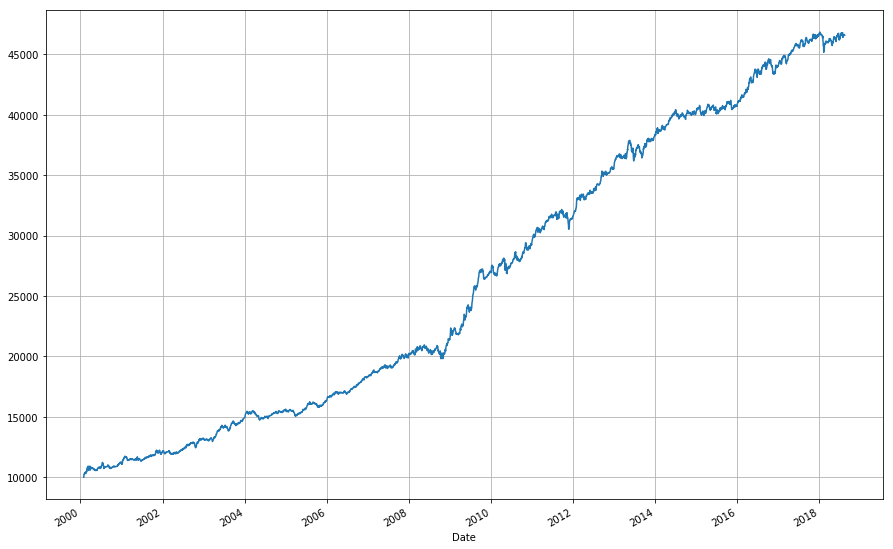

In [34]:
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

symbols =['VCVSX','VWEHX','VFIIX','VFITX','VWAHX']
# symbols =['CWB','HYG','HYD','MBB','IEF']
cash_proxy = 'CASHX'
# cash_proxy = 'SHY'
risk_free = 0

rs_lookback = 1
risk_lookback = 2
n_top = 2

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))
    
# Define which online source one should use
data_source = 'yahoo'

# data = pd.DataFrame (columns=tickers)
# for symbol in tickers :
#     url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
#     data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)

inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
MA = prices_m.rolling(2).mean()[symbols]
# absolute_momentum_rule = returns > 0
absolute_momentum_rule = MA > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.reindex(rebalance_dates)[symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

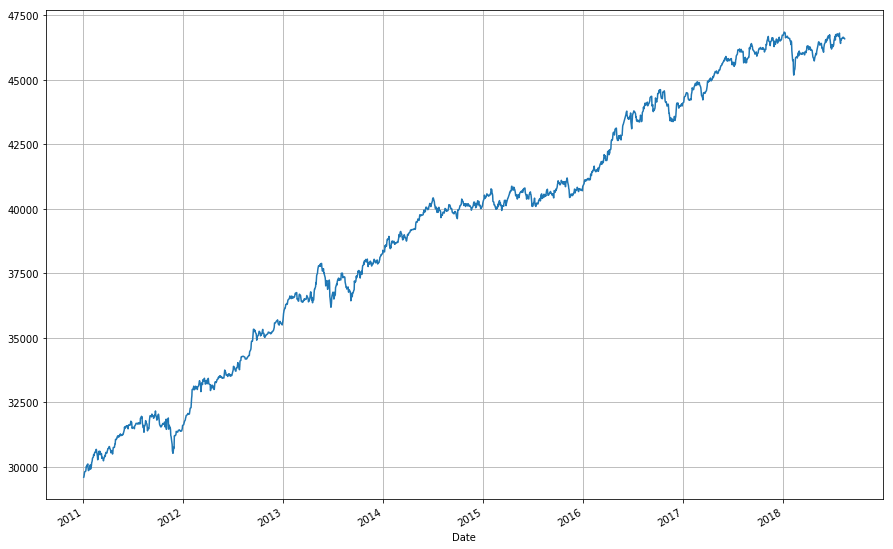

In [35]:
p_value[p_value.index > datetime(2011,1,1)].plot(figsize=(15,10), grid=True)

In [36]:
p_holdings[p_holdings.index > datetime(2011,1,1)].reindex(rebalance_dates).round(2).dropna()[:5]

Symbols,VCVSX,VFIIX,VFITX,VWAHX,VWEHX,CASHX
Date,,,,,,
2011-01-31,1641.14,0.0,0.00,0.00,4026.54,0.0
2011-02-28,1631.44,0.0,0.00,2021.93,0.00,0.0
2011-03-31,1625.03,0.0,0.00,0.00,4042.63,0.0
2011-04-29,0.00,0.0,1668.96,0.00,4033.01,0.0
2011-05-31,0.00,0.0,1659.42,2007.90,0.00,0.0


In [37]:
prices_m[prices_m.index > datetime(2011,1,1)][:5]

Symbols,VCVSX,VFIIX,VFITX,VWAHX,VWEHX
Date,,,,,
2011-01-31,9.154365,8.538572,9.209835,7.459075,3.731145
2011-02-28,9.381221,8.560940,9.170086,7.569490,3.778429
2011-03-31,9.427566,8.575337,9.159480,7.547019,3.789618
2011-04-29,9.535157,8.693808,9.306338,7.667400,3.851202
2011-05-31,9.494812,8.805351,9.470610,7.826968,3.874382


In [39]:
MA[MA.index > datetime(2011,1,1)][:5]

Symbols,VCVSX,VWEHX,VFIIX,VFITX,VWAHX
Date,,,,,
2011-01-31,9.054280,3.694503,8.531016,9.196459,7.503477
2011-02-28,9.267793,3.754787,8.549756,9.189960,7.514283
2011-03-31,9.404393,3.784024,8.568139,9.164783,7.558255
2011-04-29,9.481361,3.820410,8.634573,9.232909,7.607209
2011-05-31,9.514985,3.862792,8.749579,9.388474,7.747184


In [40]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2000-01-31 00:00:00 - 2018-08-14 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
365.94%             1.88  8.66%   -5.47%

Annualized Returns:
mtd    3m     6m     ytd     1y     3y     5y     10y    incep.
-----  -----  -----  ------  -----  -----  -----  -----  --------
0.04%  0.32%  2.31%  -0.30%  1.65%  4.80%  4.53%  8.59%  8.66%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.88     1.74       1.48
mean    8.42%    8.42%      8.35%
vol     4.48%    4.84%      5.65%
skew    -0.05    0.58       1.66
kurt    3.45     1.95       4.96
best    1.93%    6.17%      25.91%
worst   -1.57%   -2.83%     -0.30%

Drawdowns:
max     avg       # days
------  ------  --------
-5.47%  -0.73%     20.36

Misc:
---------------  ------
avg. up month    1.29%
avg. down month  -0.90%
up year %        94.44%
12m up %         99.53%
-----

In [42]:
show_return_table(p_value)

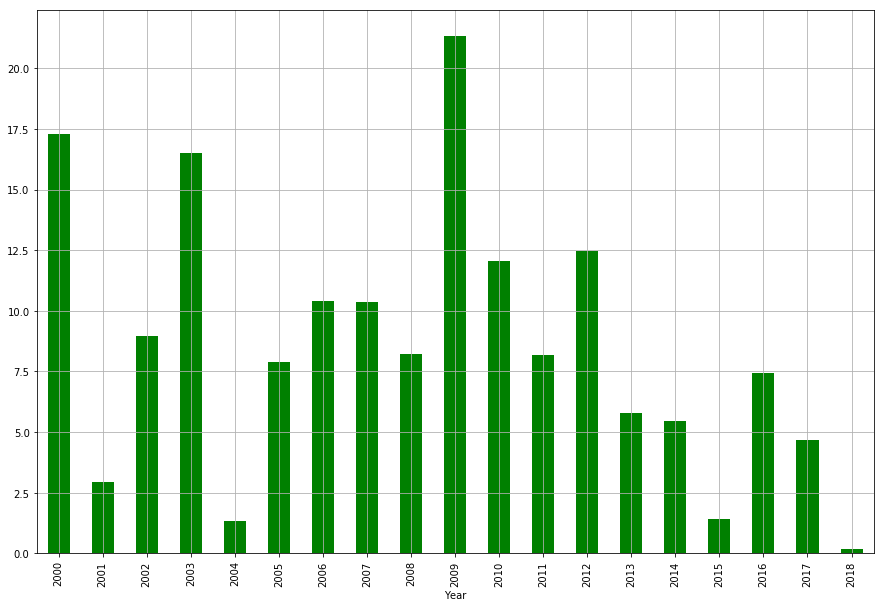

In [43]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# RS0002 (SMBS01)

         inception
Symbols           
FAGIX   1999-12-31
MMHYX   1999-12-31
VFIIX   1999-12-31
FIRST BUY DATE = 2000-03-31 00:00:00



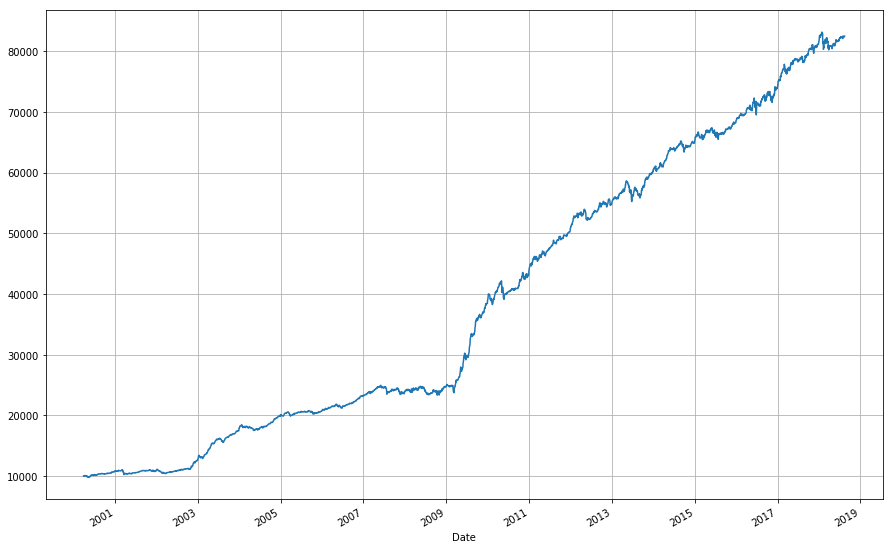

In [45]:
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

symbols =['MMHYX','FAGIX','VFIIX']
cash_proxy = 'CASHX'
risk_free = 0

rs_lookback = 3
risk_lookback = 2
n_top = 1

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))
    
# Define which online source one should use
data_source = 'yahoo'

# data = pd.DataFrame (columns=tickers)
# for symbol in tickers :
#     url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
#     data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)

inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
MA = prices_m.rolling(2).mean()[symbols]
# absolute_momentum_rule = returns > 0
absolute_momentum_rule = MA > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.reindex(rebalance_dates)[symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [46]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2000-03-31 00:00:00 - 2018-08-14 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
724.80%             2.49  12.17%  -7.37%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y     10y     incep.
-----  -----  -----  -----  -----  -----  -----  ------  --------
0.00%  1.47%  1.80%  1.33%  5.24%  7.51%  7.74%  13.31%  12.17%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.49     1.80       0.89
mean    11.62%   11.72%     12.72%
vol     4.67%    6.49%      14.29%
skew    0.10     0.87       2.36
kurt    5.85     4.64       5.57
best    2.35%    9.07%      56.88%
worst   -1.93%   -5.33%     1.30%

Drawdowns:
max     avg       # days
------  ------  --------
-7.37%  -0.82%     22.23

Misc:
---------------  -------
avg. up month    1.58%
avg. down month  -1.19%
up year %        100.00%
12m up %         96.21%
-

In [47]:
show_return_table(p_value)

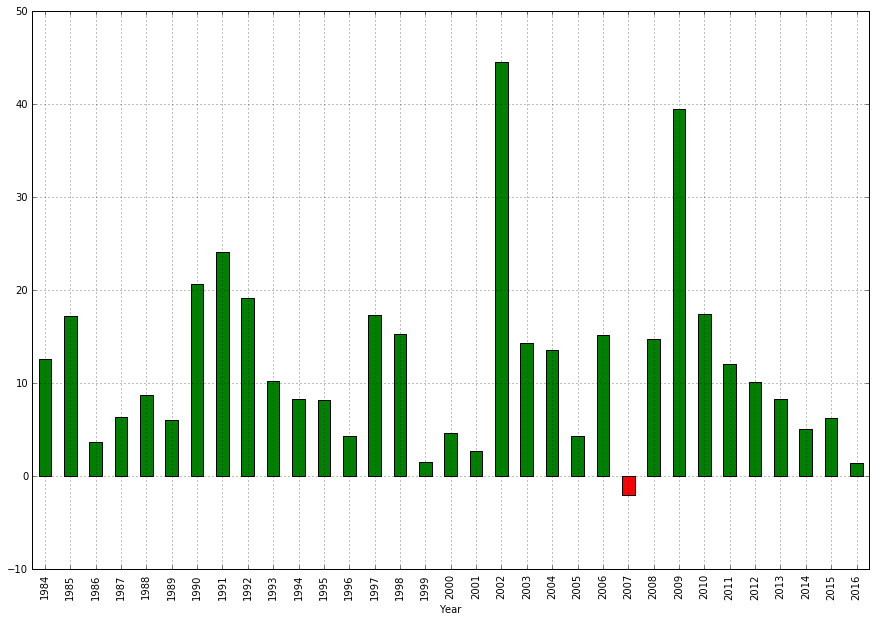

In [9]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# RS0003 (SQBS01)

         inception
Symbols           
FAGIX   1999-12-31
MMHYX   1999-12-31
VFIIX   1999-12-31
FIRST BUY DATE = 2000-01-31 00:00:00



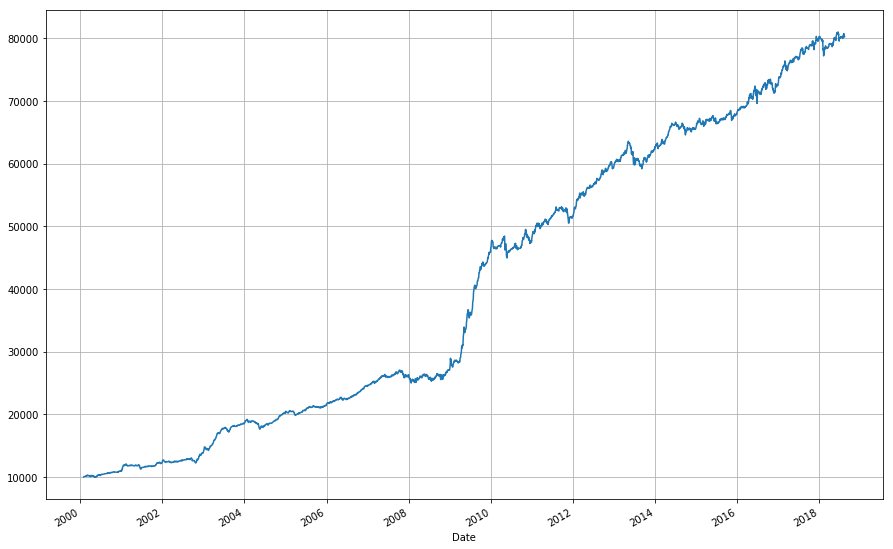

In [49]:
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

symbols =['MMHYX','FAGIX','VFIIX']
cash_proxy = 'CASHX'
risk_free = 0

rs_lookback = 1
risk_lookback =1
n_top = 1

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))
    
# Define which online source one should use
data_source = 'yahoo'

# data = pd.DataFrame (columns=tickers)
# for symbol in tickers :
#     url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
#     data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = web.DataReader(tickers, data_source, start_date, end_date)
data = panel_data['Adj Close'].sort_index(ascending=True)

inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='M', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
MA = prices_m.rolling(2).mean()[symbols]
# absolute_momentum_rule = returns > 0
absolute_momentum_rule = MA > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.reindex(rebalance_dates)[symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [51]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2000-01-31 00:00:00 - 2018-08-14 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
702.54%             2.34  11.89%  -8.13%

Annualized Returns:
mtd     3m     6m     ytd    1y     3y     5y     10y     incep.
------  -----  -----  -----  -----  -----  -----  ------  --------
-0.10%  0.28%  3.07%  0.09%  3.30%  6.18%  5.91%  12.10%  11.89%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.34     1.61       0.77
mean    11.37%   11.51%     12.59%
vol     4.86%    7.15%      16.32%
skew    0.41     1.84       3.08
kurt    7.82     8.26       10.40
best    3.02%    13.10%     70.98%
worst   -1.93%   -5.18%     0.09%

Drawdowns:
max     avg       # days
------  ------  --------
-8.13%  -0.86%     23.44

Misc:
---------------  -------
avg. up month    1.65%
avg. down month  -1.10%
up year %        100.00%
12m up %         96.7

In [52]:
show_return_table(p_value)

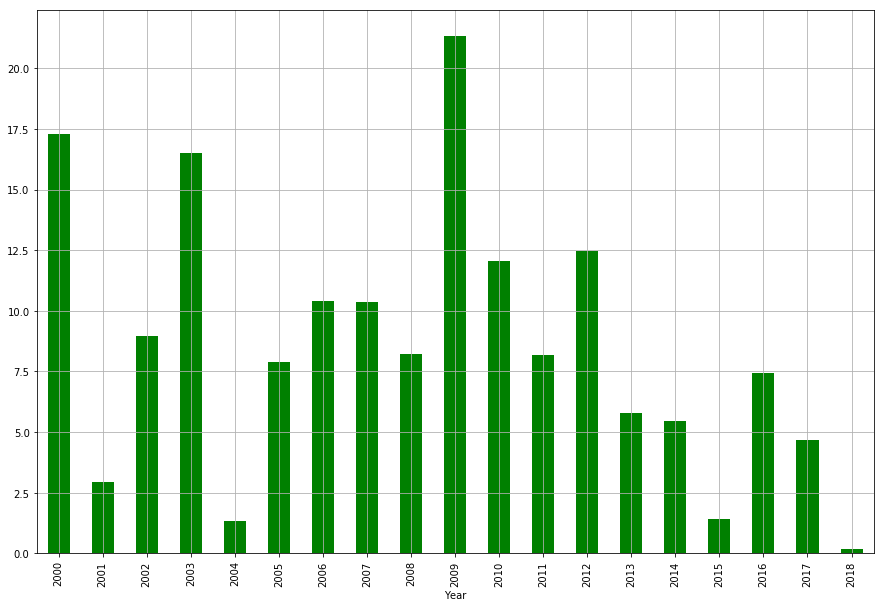

In [53]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

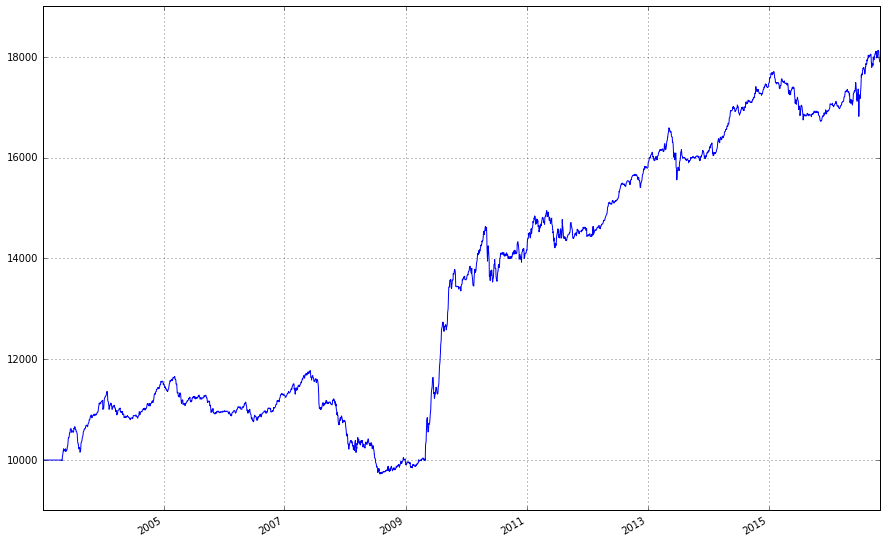

In [25]:
# Zipline results (from Pycharm)

p_value1 = pd.read_pickle('E:\\NOTEBOOKS\\Quantopian\\Strategies\\rs0003F.pkl').portfolio_value
p_value1.plot(figsize=(15, 10), grid=True)

In [109]:
start = dt.datetime(2010,4,30)
end = dt.datetime(2011,11,1)
df = pd.DataFrame(index=p_value[start:end][:-1].index)
p1 = p_value[start:end][:-1]
p2 = p_value1[start:end]
df['BT'] = (p1 / p1.iloc[0]).values
df['Z'] = (p2 / p2.iloc[0]).values

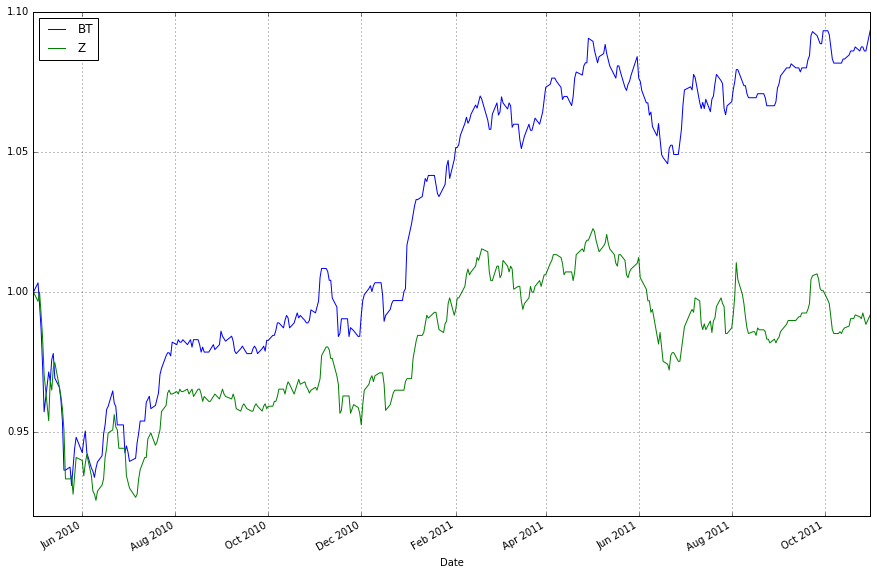

In [117]:
df.plot(figsize=(15, 10), grid=True)

In [26]:
# algo stats
ffn.calc_perf_stats(p_value1).display()

Stats for portfolio_value from 2003-01-02 21:00:00 - 2016-11-01 20:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
79.03%              1.04  4.30%   -17.45%

Annualized Returns:
mtd     3m     6m     ytd    1y     3y     5y     10y    incep.
------  -----  -----  -----  -----  -----  -----  -----  --------
-0.21%  0.95%  3.45%  5.63%  6.30%  3.79%  4.26%  4.95%  4.30%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.04     0.73       0.39
mean    4.30%    4.40%      4.29%
vol     4.15%    6.03%      11.03%
skew    -0.55    0.72       2.23
kurt    7.58     5.39       6.61
best    1.64%    8.05%      36.64%
worst   -1.94%   -5.91%     -7.76%

Drawdowns:
max      avg       # days
-------  ------  --------
-17.45%  -1.04%     46.43

Misc:
---------------  ------
avg. up month    1.25%
avg. down month  -1.01%
up year %        69.23%
12m up %     

In [27]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value1)

df.style.\
    apply(highlight_pos_neg)

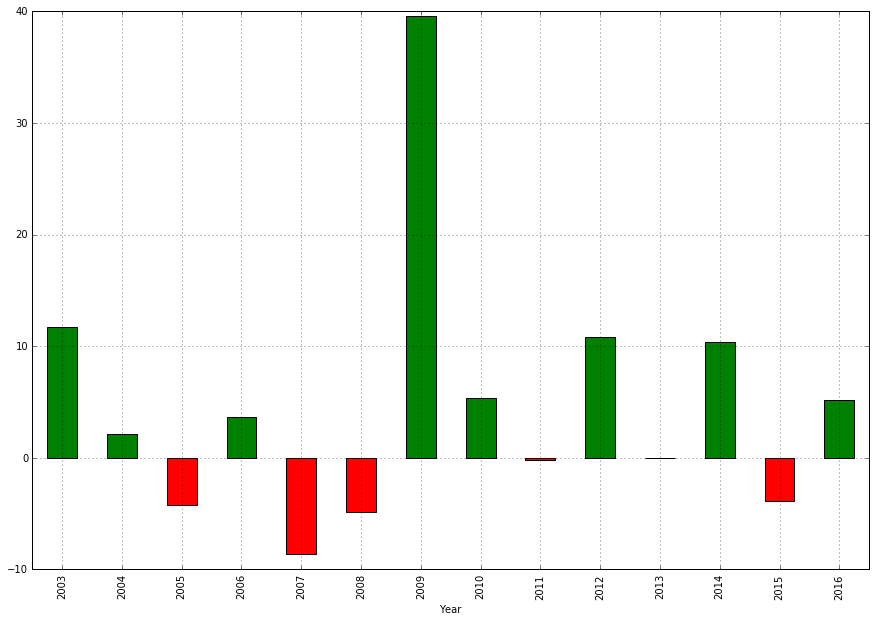

In [8]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)